# Maximum Likelihood Geodesic Regression

In [17]:
#Modulees

#jax
from jax import jacfwd, vmap
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

#numpy
import numpy as np

import pickle

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

from gp.gp import RM_EG

#scores
from models import models

#jaxgeometry
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import MLGeodesicRegression
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

In [18]:
#Hyper Parameters
T = 0.5
score_path = "scores"
s2_approx = 0
s1loss_type = "dsm"
s2loss_type = "dsm"
s2_type = "s1s2"
seed = 2712

figure_path = '../figures/ml_regression/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [19]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}_{s2loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)
    layers_s1, layers_s2 = layers

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers_s1)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers_s2, layers_beta=layers_s2,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers_s1), 
                    models.MLP_s2(layers_alpha=layers_s2, 
                                  layers_beta=layers_s2,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval

## Testing with $\mathbb{R}^{2}$

In [4]:
M, x0, ScoreEval = load_score_model("Euclidean", 2)

using M.Exp for Logarithm


### Generate Test Data

In [5]:
eps = 0.1*np.random.normal(size=(100,2))
X_obs = (vmap(lambda t: jnp.zeros(2)+t*jnp.ones(2))(jnp.linspace(0.1,1,100))+eps, jnp.zeros(100))
X = jnp.linspace(0.1,1,100)
v = jnp.ones(2)*0.5
sigma = 0.5
mu = (jnp.ones(2)*1.0, jnp.zeros(1))

### Testing with True Gradient

In [6]:
mlgr = MLGeodesicRegression(M,
                            lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                            lambda x,y,t: M.gradt_log_hk(x,y,t),
                            Exp = lambda x,v: M.Exp(x,v),
                            gradp_exp = lambda x,v: jacfwdx(lambda x: M.Exp(x,v))(x)[0],
                            gradv_exp = lambda x,v: jacfwd(lambda v: M.Exp(x,v))(v)[0],
                            max_iter=1000,
                            lr_rm=0.01,
                            lr_euc=0.01,
                            min_t = 1e-3,
                            max_t = 1.0,
                            )

In [7]:
mlgr.fit(X_obs, X, v, mu, jnp.array([sigma]).reshape(1), method='Gradient')

Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
E

In [8]:
print(f"The estimated values are: \n\t-sigma = {mlgr.sigma}\n\t-v = {mlgr.v}\n\t-mu = {mlgr.p}")

The estimated values are: 
	-sigma = [0.18603859]
	-v = [0.97349074 1.05622078]
	-mu = (Array([ 0.01759112, -0.05514093], dtype=float64), Array([0.], dtype=float64))


Text(0, 0.5, '$x^{2}$')

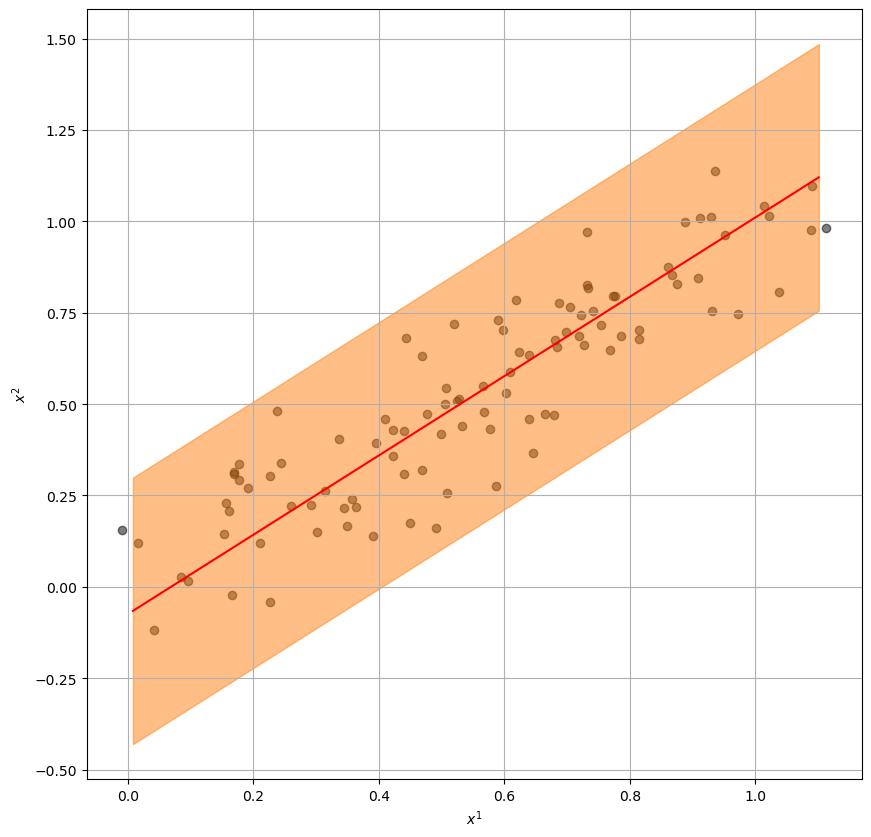

In [9]:
plot1 = mlgr.p[0]+jnp.einsum('i,j->ij',jnp.linspace(jnp.min(X_obs[0][:,0]), jnp.max(X_obs[0][:,0]),100),mlgr.v)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(plot1[:,0], plot1[:,1], color='red')
ax.scatter(X_obs[0][:,0],X_obs[0][:,1], color='black', alpha=0.5)
ax.fill_between(
    plot1[:,0].ravel(),
    plot1[:,1] - 1.96 * mlgr.sigma*jnp.ones_like(plot1[:,1]),
    plot1[:,1] + 1.96 * mlgr.sigma*jnp.ones_like(plot1[:,1]),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

### Testing with Learned Gradient

In [15]:
mlgr = MLGeodesicRegression(M,
                            ScoreEval.grady_log,
                            ScoreEval.gradt_log,
                            Exp = lambda x,v: M.Exp(x,v),
                            gradp_exp = lambda x,v: jacfwdx(lambda x: M.Exp(x,v))(x)[0],
                            gradv_exp = lambda x,v: jacfwd(lambda v: M.Exp(x,v))(v)[0],
                            max_iter=1000,
                            lr_rm=0.01,
                            lr_euc=0.01,
                            )

In [ ]:
mlgr.fit(X_obs, X, v, mu, jnp.array([sigma]).reshape(1), method='Gradient')

Epoch 1/1000
Epoch 2/1000
Epoch 3/1000


In [ ]:
print(f"The estimated values are: \n\t-sigma = {mlgr.sigma}\n\t-v = {mlgr.v}\n\t-mu = {mlgr.p}")

Text(0, 0.5, '$x^{2}$')

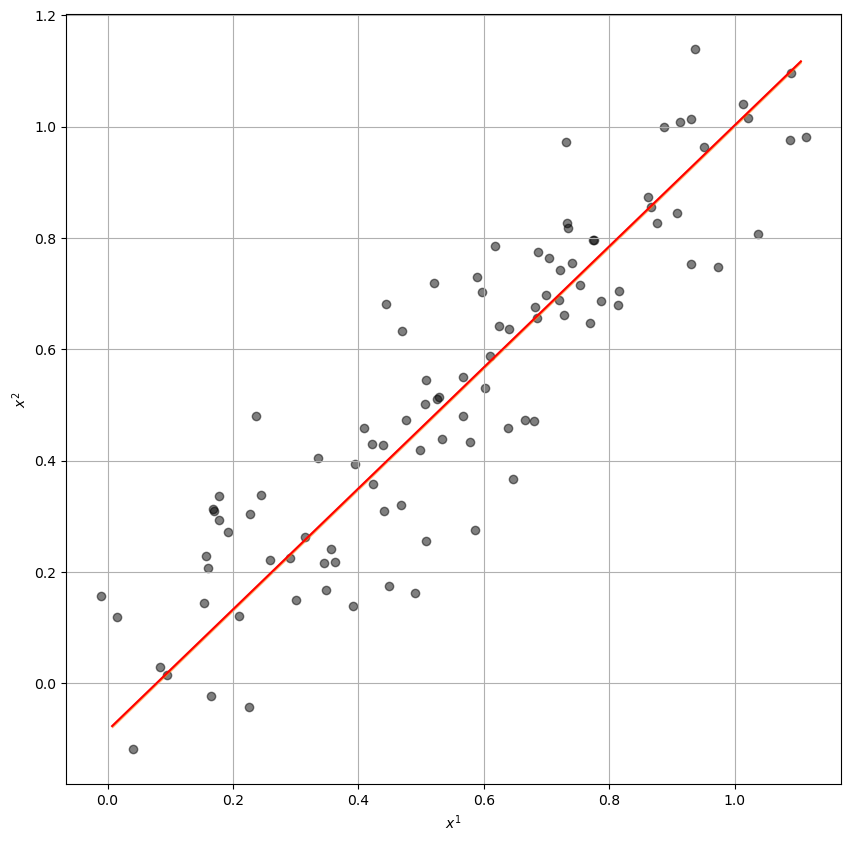

In [13]:
plot1 = mlgr.p[0]+jnp.einsum('i,j->ij',jnp.linspace(jnp.min(X_obs[0][:,0]), jnp.max(X_obs[0][:,0]),100),mlgr.v)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(plot1[:,0], plot1[:,1], color='red')
ax.scatter(X_obs[0][:,0],X_obs[0][:,1], color='black', alpha=0.5)
ax.fill_between(
    plot1[:,0].ravel(),
    plot1[:,1] - 1.96 * mlgr.sigma*jnp.ones_like(plot1[:,1]),
    plot1[:,1] + 1.96 * mlgr.sigma*jnp.ones_like(plot1[:,1]),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

## Application to $\mathcal{P}(3)$ for Crypto Data

In [9]:
data_path = '../data/crypto/crypto.pkl'
N_data = 100

In [7]:
with open(data_path, 'rb') as f:
    data_dict = pickle.load(f)

In [11]:
regression_data = jnp.array(data_dict['cov'].iloc[:N_data].values).reshape(-1,5,5)

In [23]:
X_obs = (vmap(lambda c: M.invF((c,c)))(regression_data), regression_data)

In [24]:
M, x0, ScoreEval = load_score_model("SPDN", regression_data.shape[-1])

using M.Exp for Logarithm


In [25]:
mlgr = MLGeodesicRegression(M,
                            ScoreEval.grady_log,
                            ScoreEval.gradt_log,
                            Exp = lambda x,v: M.Exp(x,v),
                            gradp_exp = lambda x,v: jacfwdx(lambda x: M.Exp(x,v))(x)[0],
                            gradv_exp = lambda x,v: jacfwd(lambda v: M.Exp(x,v))(v)[0],
                            max_iter=1000,
                            lr_rm=0.01,
                            lr_euc=0.01,
                            )

In [26]:
mlgr.fit(X_obs, X, v, mu, jnp.array([sigma]).reshape(1), method='Gradient')

NameError: name 'X' is not defined